### Calibrate water-level model using coops obs and merged KHSE winds (gaps filled with coops winds)

Common hourly span: 2010-04-27 18:00:00+00:00 to 2025-12-23 16:00:00+00:00 n= 137255
Valid hourly WL: 136461
Valid hourly wind: 137111

Zero-lag correlations with hourly WL (max):
  corr(wl, U^2_NW)   = 0.343
  corr(wl, U^2_NWNE) = 0.428

Best-lag results (wind leads WL by lag hours):
  NW   : best lag = 1 h, r = 0.345
  NW+NE: best lag = 0 h, r = 0.428


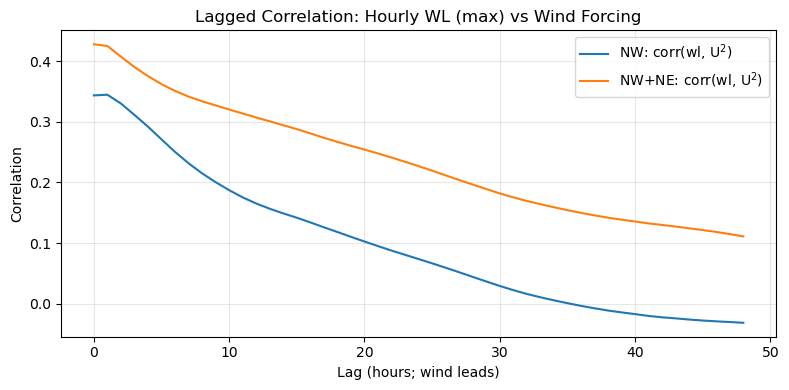


Calibration results (hourly WL max; linear model):
  NW   : wl = 0.005384 * U2(t-1h) + 0.1172  | r=0.345, bias=0.000 m, rmse=0.139 m
  NW+NE: wl = 0.005029 * U2(t-0h) + 0.09281  | r=0.428, bias=0.000 m, rmse=0.134 m


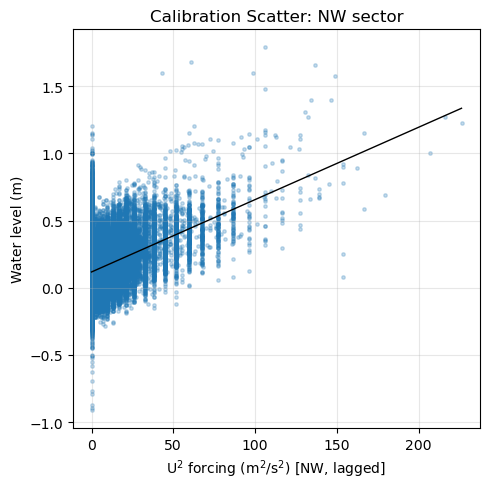

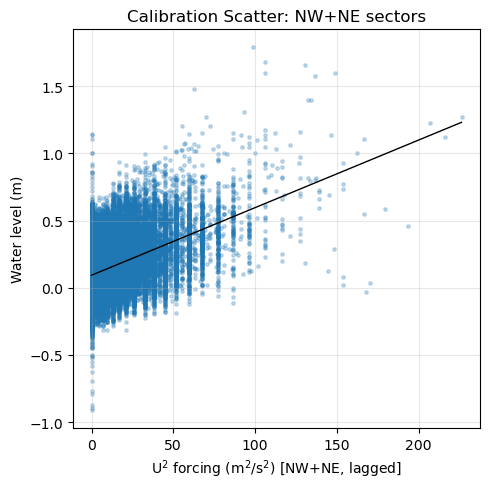

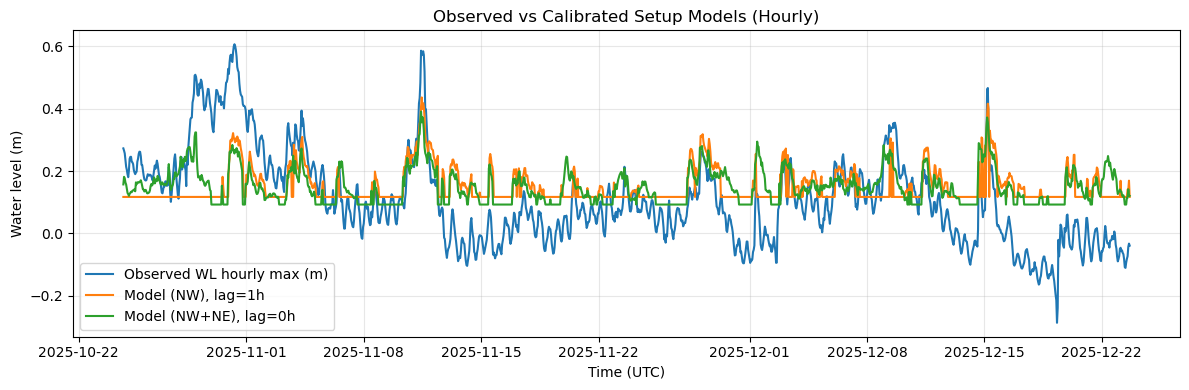


Wrote calibrated hourly dataset:
COOPS8654467_calibrated_setup_from_U2_sectors_hourly.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# INPUT FILES
# ============================================================
WIND_CSV = "KHSE_merged_with_COOPSfill_regimeAware_hourly.csv"
WL6_CSV  = "coops_8654467/COOPS_8654467_water_level_6min_MSL_metric_GMT.csv"

# Output for calibrated predictions
OUT_CAL_CSV = "COOPS8654467_calibrated_setup_from_U2_sectors_hourly.csv"

# ============================================================
# SETTINGS
# ============================================================
# lag search (hours): positive lag means wind leads WL by that many hours
LAG_MAX_H = 48

# Optional: limit analysis to a date range (UTC), or set to None
TMIN = None  # e.g., "2010-01-01"
TMAX = None  # e.g., "2025-01-01"

# ============================================================
# HELPERS
# ============================================================
def met_quadrant_masks(dfrom_deg):
    """Return boolean masks for NW and (NW+NE) using direction FROM (deg)."""
    d = (dfrom_deg % 360.0)
    m_nw = (d >= 270.0) & (d < 360.0)
    m_nwne = (d >= 270.0) | (d < 90.0)
    return m_nw, m_nwne

def safe_corr(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 50:
        return np.nan
    return float(np.corrcoef(x[m], y[m])[0, 1])

def lag_corr(series_y, series_x, lag_hours):
    """
    Corr(y(t), x(t-lag)), with lag>0 meaning x leads y.
    """
    xshift = series_x.shift(lag_hours)
    df = pd.concat([series_y, xshift], axis=1).dropna()
    if len(df) < 50:
        return np.nan
    return float(np.corrcoef(df.iloc[:,0].values, df.iloc[:,1].values)[0,1])

def fit_linear(y, x, add_intercept=True):
    """
    Fit y = a*x + b (if add_intercept), else y = a*x
    Returns (a,b, yhat) with yhat aligned to y index.
    """
    df = pd.concat([y, x], axis=1).dropna()
    if len(df) < 50:
        return np.nan, np.nan, pd.Series(index=y.index, dtype=float)

    yy = df.iloc[:,0].values.astype(float)
    xx = df.iloc[:,1].values.astype(float)

    if add_intercept:
        A = np.column_stack([xx, np.ones_like(xx)])
        (a,b), *_ = np.linalg.lstsq(A, yy, rcond=None)
    else:
        A = xx[:,None]
        (a,), *_ = np.linalg.lstsq(A, yy, rcond=None)
        b = 0.0

    yhat = pd.Series(a*xx + b, index=df.index, name="yhat")
    return float(a), float(b), yhat.reindex(y.index)

# ============================================================
# LOAD WINDS (HOURLY)
# ============================================================
w = pd.read_csv(WIND_CSV, parse_dates=["time"])
w["time"] = pd.to_datetime(w["time"], utc=True, errors="coerce")
w = w.dropna(subset=["time"]).set_index("time").sort_index()

# expected columns from your merged wind file
w["U"] = pd.to_numeric(w["wind_speed_mps"], errors="coerce")
w["Dfrom"] = pd.to_numeric(w["wind_dir_from_deg"], errors="coerce")

# ============================================================
# LOAD WATER LEVELS (6-min) AND RESAMPLE TO HOURLY
# ============================================================
wl6 = pd.read_csv(WL6_CSV, parse_dates=["Date Time"])
wl6["time"] = pd.to_datetime(wl6["Date Time"], utc=True, errors="coerce")
wl6 = wl6.dropna(subset=["time"]).set_index("time").sort_index()
wl6 = wl6.dropna(subset=["Date Time"])


wl6["wl"] = pd.to_numeric(wl6["Water Level"], errors="coerce")

# hourly max or hourly mean
wl_hr = wl6["wl"].resample("1h").mean()

# ============================================================
# OPTIONAL DATE CLIP
# ============================================================
if TMIN is not None or TMAX is not None:
    wl_hr = wl_hr.loc[TMIN:TMAX]
    w = w.loc[TMIN:TMAX]

# ============================================================
# ALIGN TO COMMON HOURLY INDEX
# ============================================================
t0 = max(w.index.min(), wl_hr.index.min())
t1 = min(w.index.max(), wl_hr.index.max())
idx = pd.date_range(t0.floor("1h"), t1.ceil("1h"), freq="1h", tz="UTC")

df = pd.DataFrame(index=idx)
df.index.name = "time"
df["wl_hr_max"] = wl_hr.reindex(idx)

df["U"] = w["U"].reindex(idx)
df["Dfrom"] = w["Dfrom"].reindex(idx)

# Build sector forcings: U^2 where in sector, else 0 (so “no forcing” outside sector)
m_nw, m_nwne = met_quadrant_masks(df["Dfrom"].values)
df["U2"] = df["U"]**2
df["U2_NW"] = df["U2"].where(m_nw, 0.0)
df["U2_NWNE"] = df["U2"].where(m_nwne, 0.0)

print("Common hourly span:", df.index.min(), "to", df.index.max(), "n=", len(df))
print("Valid hourly WL:", int(df["wl_hr_max"].notna().sum()))
print("Valid hourly wind:", int(df["U"].notna().sum()))

# ============================================================
# ZERO-LAG CORRELATIONS
# ============================================================
r_nw   = safe_corr(df["wl_hr_max"], df["U2_NW"])
r_nwne = safe_corr(df["wl_hr_max"], df["U2_NWNE"])

print("\nZero-lag correlations with hourly WL (max):")
print(f"  corr(wl, U^2_NW)   = {r_nw:.3f}")
print(f"  corr(wl, U^2_NWNE) = {r_nwne:.3f}")

# ============================================================
# LAG SWEEP (winds lead WL)
# ============================================================
lags = np.arange(0, LAG_MAX_H + 1, 1)
corr_nw = np.array([lag_corr(df["wl_hr_max"], df["U2_NW"],   L) for L in lags])
corr_ne = np.array([lag_corr(df["wl_hr_max"], df["U2_NWNE"], L) for L in lags])

bestL_nw = int(lags[np.nanargmax(corr_nw)])
bestR_nw = float(np.nanmax(corr_nw))

bestL_ne = int(lags[np.nanargmax(corr_ne)])
bestR_ne = float(np.nanmax(corr_ne))

print("\nBest-lag results (wind leads WL by lag hours):")
print(f"  NW   : best lag = {bestL_nw} h, r = {bestR_nw:.3f}")
print(f"  NW+NE: best lag = {bestL_ne} h, r = {bestR_ne:.3f}")

# Plot lag correlations
plt.figure(figsize=(8,4))
plt.plot(lags, corr_nw,  label="NW: corr(wl, U$^2$)")
plt.plot(lags, corr_ne,  label="NW+NE: corr(wl, U$^2$)")
plt.xlabel("Lag (hours; wind leads)")
plt.ylabel("Correlation")
plt.title("Lagged Correlation: Hourly WL (max) vs Wind Forcing")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# CALIBRATION: eta = a * U2_sector(t-lag) + b
# ============================================================
# Shift forcing by best lag (x(t-lag))
x_nw   = df["U2_NW"].shift(bestL_nw)
x_nwne = df["U2_NWNE"].shift(bestL_ne)

y = df["wl_hr_max"]

a_nw, b_nw, yhat_nw = fit_linear(y, x_nw, add_intercept=True)
a_ne, b_ne, yhat_ne = fit_linear(y, x_nwne, add_intercept=True)

# Skill metrics
def skill(y, yhat):
    d = pd.concat([y, yhat], axis=1).dropna()
    if len(d) < 50:
        return np.nan, np.nan, np.nan
    err = d.iloc[:,1] - d.iloc[:,0]
    bias = float(err.mean())
    rmse = float(np.sqrt((err**2).mean()))
    r = float(np.corrcoef(d.iloc[:,0].values, d.iloc[:,1].values)[0,1])
    return bias, rmse, r

bias_nw, rmse_nw, rfit_nw = skill(y, yhat_nw)
bias_ne, rmse_ne, rfit_ne = skill(y, yhat_ne)

print("\nCalibration results (hourly WL max; linear model):")
print(f"  NW   : wl = {a_nw:.4g} * U2(t-{bestL_nw}h) + {b_nw:.4g}  | r={rfit_nw:.3f}, bias={bias_nw:.3f} m, rmse={rmse_nw:.3f} m")
print(f"  NW+NE: wl = {a_ne:.4g} * U2(t-{bestL_ne}h) + {b_ne:.4g}  | r={rfit_ne:.3f}, bias={bias_ne:.3f} m, rmse={rmse_ne:.3f} m")

# ============================================================
# SCATTERPLOTS (calibrated)
# ============================================================
# NW
d1 = pd.concat([y, x_nw, yhat_nw], axis=1).dropna()
plt.figure(figsize=(5,5))
plt.scatter(d1.iloc[:,1], d1.iloc[:,0], s=6, alpha=0.25)
xx = np.linspace(d1.iloc[:,1].min(), d1.iloc[:,1].max(), 100)
plt.plot(xx, a_nw*xx + b_nw, "k-", lw=1)
plt.xlabel("U$^2$ forcing (m$^2$/s$^2$) [NW, lagged]")
plt.ylabel("Water level (m)")
plt.title("Calibration Scatter: NW sector")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# NW+NE
d2 = pd.concat([y, x_nwne, yhat_ne], axis=1).dropna()
plt.figure(figsize=(5,5))
plt.scatter(d2.iloc[:,1], d2.iloc[:,0], s=6, alpha=0.25)
xx = np.linspace(d2.iloc[:,1].min(), d2.iloc[:,1].max(), 100)
plt.plot(xx, a_ne*xx + b_ne, "k-", lw=1)
plt.xlabel("U$^2$ forcing (m$^2$/s$^2$) [NW+NE, lagged]")
plt.ylabel("Water level (m)")
plt.title("Calibration Scatter: NW+NE sectors")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# TIME SERIES PLOT (subset: last ~60 days with data)
# ============================================================
# Choose a window with valid data
valid = df["wl_hr_max"].dropna()
if len(valid) > 0:
    t_end = valid.index.max()
    t_start = t_end - pd.Timedelta(days=60)
    sub = df.loc[t_start:t_end].copy()

    plt.figure(figsize=(12,4))
    plt.plot(sub.index, sub["wl_hr_max"], label="Observed WL hourly max (m)")
    plt.plot(sub.index, yhat_nw.loc[sub.index], label=f"Model (NW), lag={bestL_nw}h")
    plt.plot(sub.index, yhat_ne.loc[sub.index], label=f"Model (NW+NE), lag={bestL_ne}h")
    plt.xlabel("Time (UTC)")
    plt.ylabel("Water level (m)")
    plt.title("Observed vs Calibrated Setup Models (Hourly)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================================
# SAVE CALIBRATED RESULTS
# ============================================================
out = df.copy()
out["U2_NW_lagged"] = x_nw
out["U2_NWNE_lagged"] = x_nwne
out["wl_pred_NW"] = yhat_nw
out["wl_pred_NWNE"] = yhat_ne

out.reset_index().to_csv(OUT_CAL_CSV, index=False)
print("\nWrote calibrated hourly dataset:")
print(OUT_CAL_CSV)
